In [1]:
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

import cnn_builder as cbuild
import cnn_methods as cfunc
import config
import csv
import helper_fxns as hf
import importlib
import matplotlib.pyplot as plt
import numpy as np
import operator
import os
import pandas as pd
import random
%matplotlib inline

Using TensorFlow backend.


In [26]:
importlib.reload(config)
importlib.reload(cfunc)
importlib.reload(hf)
importlib.reload(cbuild)
C = config.Config()

In [3]:
cbuild.overnight_run(C)

6cls accuracy: 0.505882352941  - average: 0.505882352941
3cls accuracy: 0.705882352941  - average: 0.705882352941
6cls accuracy: 0.423529411765  - average: 0.464705882353
3cls accuracy: 0.658823529412  - average: 0.682352941176
6cls accuracy: 0.470588235294  - average: 0.466666666667
3cls accuracy: 0.6  - average: 0.654901960784
6cls accuracy: 0.411764705882  - average: 0.452941176471
3cls accuracy: 0.647058823529  - average: 0.652941176471


C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


KeyboardInterrupt: 

In [27]:
model = cbuild.build_cnn(C, 'adam', f=[64,128,128], dropout=[0.1,0.1], padding=['same','valid'], dilation_rate=(1,1,1))#Adam(lr=.005)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_29 (InputLayer)            (None, 24, 24, 12, 1) 0                                            
____________________________________________________________________________________________________
input_30 (InputLayer)            (None, 24, 24, 12, 1) 0                                            
____________________________________________________________________________________________________
input_31 (InputLayer)            (None, 24, 24, 12, 1) 0                                            
____________________________________________________________________________________________________
conv3d_36 (Conv3D)               (None, 24, 24, 12, 64 1792        input_29[0][0]                   
___________________________________________________________________________________________

model = cbuild.run_cnn(model, C)

In [28]:
nb_classes = len(C.classes_to_include)
voi_df = pd.read_csv(C.art_voi_path)
orig_data_dict, num_samples = cfunc.collect_unaug_data(C, voi_df)
print(num_samples)

avg_X2 = {}
for cls in C.classes_to_include:
    avg_X2[cls] = np.mean(orig_data_dict[cls][1], axis=0)

{'hemangioma': 63, 'cyst': 79, 'hcc': 99, 'colorectal': 60, 'cholangio': 49, 'fnh': 69}


In [29]:
train_ids = {} #filenames of training set originals
test_ids = {} #filenames of test set
X_test = []
X2_test = []
Y_test = []
Z_test = []
X_train_orig = []
X2_train_orig = []
Y_train_orig = []
Z_train_orig = []

train_samples = {}

for cls_num, cls in enumerate(orig_data_dict):
    cls_num = C.classes_to_include.index(cls)

    train_samples[cls] = round(num_samples[cls]*C.train_frac)

    order = np.random.permutation(list(range(num_samples[cls])))
    train_ids[cls] = list(orig_data_dict[cls][2][order[:train_samples[cls]]])
    test_ids[cls] = list(orig_data_dict[cls][2][order[train_samples[cls]:]])

    X_test = X_test + list(orig_data_dict[cls][0][order[train_samples[cls]:]])
    X2_test = X2_test + list(orig_data_dict[cls][1][order[train_samples[cls]:]])
    Y_test = Y_test + [[0] * cls_num + [1] + [0] * (nb_classes - cls_num - 1)] * \
                        (num_samples[cls] - train_samples[cls])
    Z_test = Z_test + test_ids[cls]

    X_train_orig = X_train_orig + list(orig_data_dict[cls][0][order[:train_samples[cls]]])
    X2_train_orig = X2_train_orig + list(orig_data_dict[cls][1][order[:train_samples[cls]]])
    Y_train_orig = Y_train_orig + [[0] * cls_num + [1] + [0] * (nb_classes - cls_num - 1)] * \
                        (train_samples[cls])
    Z_train_orig = Z_train_orig + train_ids[cls]

    print("%s has %d samples for training (%d after augmentation) and %d for testing" %
          (cls, train_samples[cls], train_samples[cls] * C.aug_factor, num_samples[cls] - train_samples[cls]))

#Y_test = np_utils.to_categorical(Y_test, nb_classes)
#Y_train_orig = np_utils.to_categorical(Y_train_orig, nb_classes)
X_test = [np.array(X_test), np.array(X2_test)]
X_train_orig = [np.array(X_train_orig), np.array(X2_train_orig)]

Y_test = np.array(Y_test)
Y_train_orig = np.array(Y_train_orig)

Z_test = np.array(Z_test)
Z_train_orig = np.array(Z_train_orig)

X_test = cfunc.separate_phases(X_test)
X_train_orig = cfunc.separate_phases(X_train_orig)

hemangioma has 50 samples for training (1500 after augmentation) and 13 for testing
cyst has 63 samples for training (1890 after augmentation) and 16 for testing
hcc has 79 samples for training (2370 after augmentation) and 20 for testing
colorectal has 48 samples for training (1440 after augmentation) and 12 for testing
cholangio has 39 samples for training (1170 after augmentation) and 10 for testing
fnh has 55 samples for training (1650 after augmentation) and 14 for testing


In [30]:
#early_stopping = EarlyStopping(monitor='acc', min_delta=0.01, patience=4)
train_generator = cbuild.train_generator_func(C, train_ids, voi_df, avg_X2, n=6, n_art=0)
hist = model.fit_generator(train_generator, steps_per_epoch=200, epochs=20, validation_data=[X_test, Y_test])#, callbacks=[early_stopping])

Epoch 1/20
200/200 [==============================] - 41s - loss: 0.8729 - acc: 0.7183 - val_loss: 1.4409 - val_acc: 0.3882
Epoch 2/20
200/200 [==============================] - 38s - loss: 0.6623 - acc: 0.8014 - val_loss: 1.1028 - val_acc: 0.5412
Epoch 3/20
200/200 [==============================] - 37s - loss: 0.5387 - acc: 0.8429 - val_loss: 0.6374 - val_acc: 0.7529
Epoch 4/20
200/200 [==============================] - 38s - loss: 0.4490 - acc: 0.8761 - val_loss: 0.7636 - val_acc: 0.6941
Epoch 5/20
200/200 [==============================] - 38s - loss: 0.3950 - acc: 0.8890 - val_loss: 0.6104 - val_acc: 0.7412
Epoch 6/20
200/200 [==============================] - 38s - loss: 0.3450 - acc: 0.9017 - val_loss: 0.7047 - val_acc: 0.7176
Epoch 7/20
200/200 [==============================] - 38s - loss: 0.2919 - acc: 0.9206 - val_loss: 0.5826 - val_acc: 0.8000
Epoch 8/20
200/200 [==============================] - 39s - loss: 0.2441 - acc: 0.9383 - val_loss: 0.7104 - val_acc: 0.7176
Epoch 9/

KeyboardInterrupt: 

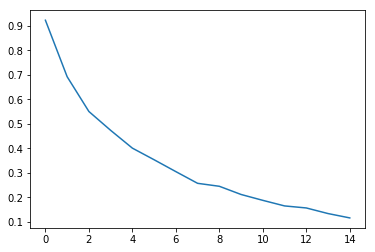

In [369]:
plt.plot(hist.history['loss'])

hist = model.fit(X_train2, Y_train2, batch_size=32, epochs=200, validation_data=(X_test, Y_test), callbacks=[early_stopping])

In [363]:
voi_df_art = pd.read_csv(C.art_voi_path)
voi_df_ven = pd.read_csv(C.ven_voi_path)
voi_df_eq = pd.read_csv(C.eq_voi_path)

with open(C.small_voi_path, 'r') as csv_file:
    reader = csv.reader(csv_file)
    small_vois = dict(reader)
for key in small_vois:
    small_vois[key] = [int(x) for x in small_vois[key][1:-1].split(', ')]

In [355]:
C.output_img_dir = "Z:\\OUTPUT\\12-ffffff"
C.classes_to_include

['hcc', 'cholangio', 'colorectal', 'cyst', 'hemangioma', 'fnh']

In [8]:
#plot_with_bbox(fn_list[2], cls_mapping[wrong_guesses[2]])
Y_pred = model.predict(X_test)
y_true = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_test])
y_pred = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_pred])

cm = confusion_matrix(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="weighted")

#cfunc.save_output(Z_test, y_pred, y_true, voi_df_art, small_vois, C.classes_to_include, C)

C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [227]:
Y_pred = model.predict(X_train_orig)
y_true = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_train_orig])
y_pred = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_pred])

cm = confusion_matrix(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="weighted")

cfunc.save_output(Z_train_orig, y_pred, y_true, voi_df_art, small_vois, C.classes_to_include, C)#, save_dir=C.output_img_dir+"\\training")

In [11]:
cm

array([[ 0,  0,  0,  0,  0, 20],
       [ 0,  5,  1,  0,  1,  3],
       [ 0,  1,  7,  0,  4,  0],
       [ 0,  0,  0, 15,  1,  0],
       [ 0,  0,  0,  1, 12,  0],
       [ 0,  1,  0,  0,  0, 13]], dtype=int64)

In [167]:
y_true_simp, y_pred_simp, _ = cfunc.condense_cm(y_true, y_pred, C.classes_to_include)

In [168]:
accuracy_score(y_true_simp, y_pred_simp)

0.66265060240963858

In [9]:
accuracy_score(y_true, y_pred)

0.61176470588235299

-1.0 1.0 0.114941346194


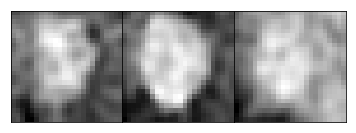

In [313]:
a=next(train_generator)
imgtrain = a[0][0][0]
img = imgtrain
hf.plot_section_auto_1ch(imgtrain[:,:,:,0])
print(np.amin(img), np.amax(img), np.mean(img))

-1.0 1.0 0.166082977132


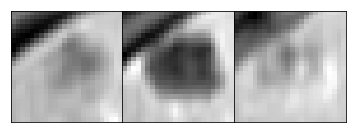

In [25]:
imgtest = X_train[0][1]
img = imgtest
print(np.amin(img), np.amax(img), np.mean(img))
hf.plot_section_auto_1ch(imgtest[:,:,:,0])

In [ ]:
87%/91%

2d: 77%/84%, 74%/80%
3d: 78%/89%
2d bn: 77%/82%, 
3d bn: 84%/87%, 74%/83%
3d bn no artif: 84%/87%, 74%/83%
3d bn/elu/dilation/3conv/64-128-100-100: 80%/86%, 82%/88%, 84%/91%

fn_list = Z_test[~np.equal(y_pred, y_true)]
wrong_guesses = np.array(y_pred)[~np.equal(y_pred, y_true)]

activ = model2.predict(X_train)
#activ = model2.predict(np.expand_dims(X_train[10],axis=0))

import operator
#print("Ground truth:", [C.classes_to_include[max(enumerate(x), key=operator.itemgetter(1))[0]] for x in Y_val[::30]])
Y_ = model.predict(X_test)
print("Predictions:", [C.classes_to_include[max(enumerate(x), key=operator.itemgetter(1))[0]] + " (%.5f%% probability)" % (max(x)*100) for x in Y_])